In [ ]:
%pip install -r requirements.txt

### Load Dataset

The hugging face `datasets` library lets you manipulate data from the HF hub (https://huggingface.co/datasets).

The ultrachat dataset https://huggingface.co/datasets/HuggingFaceH4/ultrachat_200k has examples of a multi-turn chat.

In [2]:
from datasets import load_dataset

ds = load_dataset("HuggingFaceH4/ultrachat_200k", split="train_sft")
ds[0]["messages"]

[{'content': "These instructions apply to section-based themes (Responsive 6.0+, Retina 4.0+, Parallax 3.0+ Turbo 2.0+, Mobilia 5.0+). What theme version am I using?\nOn your Collections pages & Featured Collections sections, you can easily show the secondary image of a product on hover by enabling one of the theme's built-in settings!\nYour Collection pages & Featured Collections sections will now display the secondary product image just by hovering over that product image thumbnail.\nDoes this feature apply to all sections of the theme or just specific ones as listed in the text material?",
  'role': 'user'},
 {'content': 'This feature only applies to Collection pages and Featured Collections sections of the section-based themes listed in the text material.',
  'role': 'assistant'},
 {'content': 'Can you guide me through the process of enabling the secondary image hover feature on my Collection pages and Featured Collections sections?',
  'role': 'user'},
 {'content': "Sure, here are

### Tokenization

A tokenizer takes text and converts it to the `input_ids` that we pass to the model. In the case below, I downloaded the tokenizer for Zephyr (which is a fine-tuned variant of Mistral).

Recently, tokenizers added a feature called `apply_chat_template` that takes a string of messages and gives back a formatted chat string. The models are trained with this chat format during the "alignment" phase. See more (https://huggingface.co/HuggingFaceH4/zephyr-7b-beta).

Note: all of this chat formatting is handled on the vLLM side. This is just here as an FYI.

In [41]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
tokenizer("Hello my name is")

{'input_ids': [1, 15043, 590, 1024, 338], 'attention_mask': [1, 1, 1, 1, 1]}

In [42]:
# With a chat template

print("---- input ids corresponding to the string:")
print(tokenizer.apply_chat_template(ds[0]["messages"])) 
print("\n---- actual text:")
print(tokenizer.apply_chat_template(ds[0]["messages"], tokenize=False))

---- input ids corresponding to the string:
[529, 29989, 1792, 29989, 29958, 13, 9544, 7420, 278, 13500, 310, 25704, 24472, 3476, 292, 322, 7952, 292, 6136, 29889, 2, 29871, 13, 29966, 29989, 465, 22137, 29989, 29958, 13, 4597, 1070, 15058, 322, 7952, 292, 6136, 526, 7618, 1455, 363, 7344, 292, 1781, 9045, 322, 1532, 915, 292, 297, 3196, 5837, 29901, 13, 13, 29896, 29889, 341, 2365, 2708, 263, 9045, 29891, 7688, 29901, 2169, 1070, 15058, 28057, 7688, 11581, 322, 6911, 304, 7344, 263, 9045, 29891, 7688, 29889, 739, 338, 884, 385, 15129, 982, 304, 14074, 19163, 7688, 29889, 13, 13, 29906, 29889, 4367, 29884, 778, 278, 12045, 310, 17168, 293, 10267, 2129, 29901, 1222, 6269, 895, 6911, 304, 10032, 278, 12045, 310, 17168, 293, 10267, 2129, 1316, 408, 5192, 17135, 29892, 652, 370, 10778, 322, 704, 267, 537, 29889, 13, 13, 29941, 29889, 1954, 771, 1960, 5881, 29875, 586, 6151, 1070, 9045, 29901, 1222, 6269, 895, 4857, 1960, 5881, 29875, 586, 6151, 1070, 9045, 491, 9324, 8333, 278, 5192, 322, 

In [43]:
# Add a system prompt. Only send the first N turns
N = 3

system_message = {
    "content": "You are a chatbot with the explict goal of helping the user as best as possible",
    "role": "system",
}

messages = [system_message]
messages.extend(ds[0]["messages"][:N])
messages
print(tokenizer.apply_chat_template(messages, tokenize=False))

<|system|>
You are a chatbot with the explict goal of helping the user as best as possible</s>
<|user|>
Explain the importance of regularly exercising and staying active.</s>
<|assistant|>
Regular exercise and staying active are crucial for maintaining good health and wellbeing in several ways:

1. Maintains a healthy weight: Regular exercise prevents weight gain and helps to maintain a healthy weight. It is also an excellent way to lose excess weight.

2. Reduces the risk of chronic diseases: Exercise helps to reduce the risk of chronic diseases such as heart disease, diabetes and obesity.

3. Improves cardiovascular health: Exercise improves cardiovascular health by strengthening the heart and lungs and increasing blood circulation.

4. Boosts mood and mental health: Exercise releases endorphins, which are feel-good hormones that improve mood and reduce stress and anxiety.

5. Enhances physical performance: Regular exercise improves physical performance and enhances endurance, streng

In [44]:
NUM_CONVOS = 200
ds = ds.shuffle(seed=42).select(range(NUM_CONVOS))
ds

Dataset({
    features: ['prompt', 'prompt_id', 'messages'],
    num_rows: 200
})

In [45]:
MODEL_MAX_LEN = 4096

prompt_input_output_toks = []
for messages in ds["messages"]:
    convo = [system_message]
    convo.extend(messages)
    
    for i in range(2, len(convo), 2):
        prompt = tokenizer.apply_chat_template(
            convo[:i],
            tokenize=False,
            add_generation_prompt=True  
        )
        response = convo[i]["content"]        
        num_input_tokens = len(tokenizer(prompt).input_ids)
        num_output_tokens = len(tokenizer(response).input_ids)

        if MODEL_MAX_LEN > num_input_tokens + num_output_tokens:
            prompt_input_output_toks.append((
                prompt, num_input_tokens, num_output_tokens
            ))

Token indices sequence length is longer than the specified maximum sequence length for this model (2406 > 2048). Running this sequence through the model will result in indexing errors


In [46]:
import pandas as pd
num_input_tokens_lst = []
num_output_tokens_lst = []

for prompt, input_toks, output_toks in prompt_input_output_toks:
    num_input_tokens_lst.append(input_toks)
    num_output_tokens_lst.append(output_toks)

num_input_tokens_df = pd.DataFrame(num_input_tokens_lst)
num_output_tokens_df = pd.DataFrame(num_output_tokens_lst)

print("input_tokens distribution:")
print(num_input_tokens_df.describe())

print("\noutput_tokens distribution:")
print(num_output_tokens_df.describe())

input_tokens distribution:
                 0
count   658.000000
mean    712.145897
std     554.331012
min      51.000000
25%     222.500000
50%     623.000000
75%    1028.500000
max    3066.000000

output_tokens distribution:
                 0
count   658.000000
mean    325.965046
std     231.233060
min       9.000000
25%     158.250000
50%     293.500000
75%     413.000000
max    1361.000000


Text(0.5, 1.0, 'Num Output Tokens')

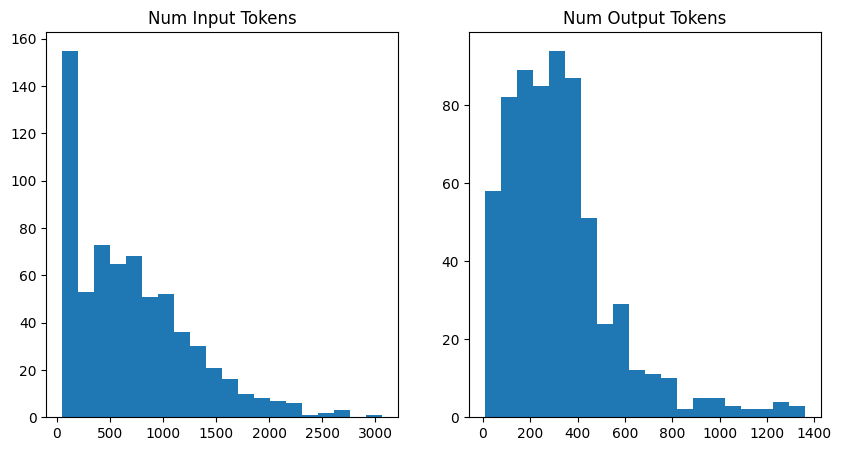

In [47]:
%matplotlib inline

import matplotlib.pyplot as plt

# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].hist(num_input_tokens_lst, bins=20)
axs[0].set_title("Num Input Tokens")
axs[1].hist(num_output_tokens_lst, bins=20)
axs[1].set_title("Num Output Tokens")

In [48]:
import random
NUM_PROMPTS = 500

samples = random.sample(prompt_input_output_toks, NUM_PROMPTS)
print(len(samples))

500


In [72]:
import aiohttp, asyncio, json

sample = random.choice(samples)
prompt, input_tokens, output_tokens = sample

pload = {
    "model": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    "prompt": prompt,
    "n": 1,
    "best_of": 1,
    "use_beam_search": False,
    "temperature": 0.0,
    "max_tokens": output_tokens,
    "ignore_eos": True,
    "stream": False,
}

api_url = "http://0.0.0.0:8000/v1/completions"
headers = {"User-Agent": "Benchmark Client"}
timeout = aiohttp.ClientTimeout(total=3 * 3600)

async with aiohttp.ClientSession(timeout=timeout) as session:
    while True:
        async with session.post(api_url, headers=headers, json=pload) as response:
            chunks = []
            async for chunk, _ in response.content.iter_chunks():
                chunks.append(chunk)
        output = b"".join(chunks).decode("utf-8")
        output = json.loads(output)

        # Re-send the request if it failed.
        if "error" not in output:
            break

print("---- response:")
print(output["choices"][0]["text"])

print("\n")
print("---- lengths:")
print(f"num_input_tokens = {input_tokens} // {output['usage']['prompt_tokens']}")
print(f"num_output_tokens = {output_tokens} // {output['usage']['completion_tokens']}")

---- response:
Classic Chicken Ala King Sauce Recipe:

Ingredients:
- 1 lb boneless, skinless chicken breasts, cut into bite-sized pieces
- 1/4 cup all-purpose flour
- 1/4 cup cornstarch
- 1/4 cup soy sauce
- 1/4 cup oyster sauce
- 1/4 cup brown sugar
- 1/4 cup rice vinegar
- 1/4 cup water
- 1 tbsp vegetable oil
- 1 tbsp minced garlic
- 1 tbsp minced ginger
- 1 tsp ground cumin
- 1 tsp ground coriander
- Salt and pepper to taste
- 1/4 cup chopped fresh cilantro
- 1/4 cup chopped green onions
- 1/4 cup chopped peanuts

Instructions:

1. Preheat the oven to 375°F (190°C).

2. In a shallow dish, mix together the flour and cornstarch.

3. In a separate bowl, whisk together the soy sauce, oyster sauce, brown sugar, rice vinegar, water, and vegetable oil.

4. In a large skillet or wok, heat the oil over medium-high heat. Add the chicken pieces and cook until browned on all sides, about 5-7 minutes. Remove the chicken from the skillet and set aside.

5. In the same skillet, add the garlic and